In [1]:
#do this later from admin: !python -m pip install --upgrade pip


# TOC

0. [Imports](#first-bullet)
1. [EDA](#1.0-bullet)
2. [Feature Engineering](#2.0-bullet)  
 2.1 [Pt 1 - Regression](#2.1-bullet)  
 2.2 [Pt 2 - Classification](#2.2-bullet)
3. [Basic Model](#3.0-bullet)  
 3.1 [Pt 1 - Regression](#3.1-bullet)  
 3.2 [Pt 2 - Classification](#3.2-bullet)
4. [Reference and Planning](#4.0-bullet)

Date Time
* General: publishedAt
* Friday (is_friday)
* Is weekend (is_weekend)
* week number (week)
* Month day (month_day)
* Month (month)
* 2 digit year number (year)

* Ignoring overall day count - possible overfit to search algorithm

Description
* Sentiment (description_sentiment)
* Overall word count (description_wordcount)
* CVEC (./data/engineered_data/description_wordvec.csv)


Tags
* Sentiment (tags_sentiment)
* Num tags (tags_wordcount)
* CVEC (./data/engineered_data/tag_wordvec.csv)

Title
* Sentiment (title_sentiment)
* Word count (title_wordcount)
* feat / ft. (title_featuring)
* Letter Count (intitle_ + a,b,c,...)
* String length (title_length)
* Which letters
* Length  
* CVEC (./data/engineered_data/title_wordvec.csv)

Ratios
* likes / views (lv_ratio)
* comments / view (comment_view_ratio)
* likes / dislikes (like_dislike_ratio)

Measures (includes log)
  * commentCount
  * dislikeCount 
  * favoriteCount 
  * likeCount: 
  * viewCount: view_log

Other
* Has content rating restriction (contentRating)
* Has any region Restriction (regionRestriction)
* Has captioned text (caption)
* Content has approved license (licensedContent)
* Duration of video (duration)
* High definition 1 or std (0) (definition)


In [1]:
#Basic
import pandas as pd
import numpy as np
#Math
import scipy as sp
from random import randint
from math import exp
import operator

#Scraping
import requests
import json

#Youtube Data API Packages: 
"""from apiclient.discovery import build
from apiclient.errors import HttpError
from oauth2client.tools import argparser
from googleapiclient.discovery import build
import argparse
from googleapiclient.errors import HttpError"""

#Modeling
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.cluster import KMeans
#from sklearn.svm import SVR
#from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import Dense, Dropout


#NLP & Text Management
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
"""from textblob import TextBlob
from wordcloud import WordCloud
from nltk.stem import PorterStemmer"""

#Time analysis
import time
import datetime
"""from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf"""

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud

%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
df_main = pd.read_csv('./data/engineered_data/data_engineered_10.9_2019.csv')

In [3]:
model_time = ['is_weekend', 'is_friday', 'year_day', 'week', 'week_day', 'month', 'month_day', 'year',  ]
model_text = ['description_sentiment', 'description_wordcount',
  'tags_sentiment', 'tags_wordcount', 'title_sentiment',
 'title_wordcount', 'title_featuring', 'title_length', ]
model_title_letter = ['intitle_a',  'intitle_b', 'intitle_c', 'intitle_d', 'intitle_e', 'intitle_f', 'intitle_g',
 'intitle_h', 'intitle_i', 'intitle_j', 'intitle_k', 'intitle_l', 'intitle_m', 'intitle_n', 'intitle_o',
 'intitle_p', 'intitle_q', 'intitle_r', 'intitle_s', 'intitle_t', 'intitle_u', 'intitle_v', 'intitle_w',
 'intitle_x', 'intitle_y', 'intitle_z',]              
model_ratios = ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio',]
model_other = ['duration', 'contentRating', 'regionRestriction',  'licensedContent', 'caption', 'definition']
measures = ['likeCount', 'dislikeCount', 'commentCount', 'viewCount',
            'view_log',  'comment_log',  'like_log', 'dislike_log', 
            'view_class' ]
non_model_cols = ['request_token', 'letter_search','channelTitle', 'tags', 'title', 'vidId','publishedAt','favoriteCount',
              'description','defaultLanguage', ]

# <a class="anchor" id="1.0-bullet"> 1. EDA</a>

# <a class="anchor" id="3.0-bullet"> 3. Basic Model</a>

In [4]:
def get_model_data(exclude_ratios=True, additional_cols_exclude=None, include_text_vecs=False, 
                   additional_cols_include=None, data=df_main):
    data=data
    if include_text_vecs:
        df_description = pd.read_csv('./data/engineered_data/description_wordvec.csv')
        df_tag = pd.read_csv('./data/engineered_data/tag_wordvec.csv')
        df_title = pd.read_csv('./data/engineered_data/title_wordvec.csv')
        df_combined = df_description.join(df_tag.set_index('vidId'), on=df_description['vidId'], how='left', rsuffix='tag')
        df_combined = df_combined.join(df_title.set_index('vidId'), on=df_combined['vidId'], how='left', rsuffix='title')

        cols_exclude_text = [col for col in df_combined.columns if '_word_' not in str(col)]
        cols_include_initial_text = [col for col in df_combined.columns if col not in cols_exclude]

        df_formodel = data.join(df_combined.set_index('vidId'), on=data['vidId'], how='left', rsuffix='text_combo')

    else:
        df_formodel = data
        
    cols_alphabet = ['intitle_a', 'intitle_d', 'intitle_f', 'intitle_g', 'intitle_i', 
                     'intitle_k', 'intitle_l','intitle_p','intitle_v','intitle_x','intitle_y' ]
    
    cols_exclude = ['vidId', 'year_day', 'month', 'tags_sentiment','title_sentiment', 'title_wordcount' ,
                    'titletext_combo', 'tagstext_combo', 'descriptiontext_combo', 'description', 'tags', 'title', 'view_log', 
                   'view_logtitle', 'view_logtag', 'Unnamed: 0title', 'Unnamed: 0']
    #
    
    if exclude_ratios:
        cols_exclude += ['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio']
    if additional_cols_exclude!=None:
        cols_exclude+=additional_cols_exclude

    cols_include = [col for col in df_formodel.columns if \
    (col in model_time or \
    col in model_text or \
    col in cols_alphabet or \
    col in model_ratios or \
    col in model_other ) and \
    col not in cols_exclude]
    
    if additional_cols_include!=None:
        cols_include+=additional_cols_include

    df_formodel = df_formodel[df_formodel['view_class']>1]     
        
    y = df_formodel.view_log
    X = df_formodel.loc[:, cols_include]
    X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=30)

    ss = StandardScaler()
    X_train_sc = ss.fit_transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    return X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel, cols_include

## <a class="anchor" id="3.0-bullet">3.0 Basline</a>

In [74]:
X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel,cols_include = get_model_data(exclude_ratios=False, 
                                                                         data=df_main.loc[:,['lv_ratio', 'comment_view_ratio', 'like_dislike_ratio', 'view_log', 'view_class']])

In [75]:
basline_gb = GradientBoostingRegressor()

basline_gb.fit(X_train_sc, y_train)
basline_gb.score(X_test_sc, y_test)

0.8709443207721751

## <a class="anchor" id="3.1-bullet">3.1 Gradient Boost</a>



In [5]:
import xgboost

In [7]:
X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel,cols_include = get_model_data(
    exclude_ratios=True, 
additional_cols_include=['year_day', 'month', 'tags_sentiment','title_sentiment', 'title_wordcount'])

In [14]:
xg_reg = xgboost.XGBRegressor(learning_rate = 0.05,
                max_depth = 10, alpha = 10, n_estimators = 200)
xg_reg.fit(X_train_sc, y_train)

xg_reg.score(X_test_sc, y_test)

0.4381167378172231

In [6]:
X_train_sc, X_test_sc, y_train, y_test, ss, df_formodel,cols_include = get_model_data(
    exclude_ratios=True, 
additional_cols_include=['year_day', 'month', 'tags_sentiment','title_sentiment', 'title_wordcount'])

gb = GradientBoostingRegressor(max_depth=3, n_estimators=180, subsample=0.9, random_state=48) #GridSearch Params
gb.fit(X_train_sc, y_train)
gb.score(X_test_sc, y_test)

0.4302629698154742

In [139]:
df_importance = pd.DataFrame(gb.feature_importances_, 
                             index=cols_include, columns=['importance'])

lin_mod = Ridge()
lin_mod.fit(X_train_sc, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [150]:
df_importance['linear_coeffs'] = lin_mod.coef_

df_importance.sort_values(by='importance', ascending=False).head(15)

,importance,linear_coeffs
duration,0.123306,-0.034307
year,0.079258,-0.603535
year_day,0.076702,-0.776984
description_wordcount,0.073869,0.137128
description_sentiment,0.066960,0.032836
title_length,0.060368,-0.229150
tags_sentiment,0.053556,-0.003973
title_sentiment,0.043572,0.050539
licensedContent,0.041394,0.439218
tags_wordcount,0.038723,0.141812


## <a class="anchor" id="3.2-bullet">3.2 Neural Net</a>



In [141]:
nn = Sequential()
#this does input and first activation
nn.add(Dense(X_train_sc.shape[1], activation='relu', input_dim=X_train_sc.shape[1]))
nn.add(Dropout(.5))
nn.add(Dense(20, activation='relu'))
nn.add(Dense(1, activation=None)) #1 neuron
nn.compile(loss='mean_squared_error', optimizer='adam')
history = nn.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=30, batch_size=50, verbose=0)
preds = nn.predict(X_test_sc)
print( 'score: ', r2_score(y_test, preds))

score:  0.277165008287958


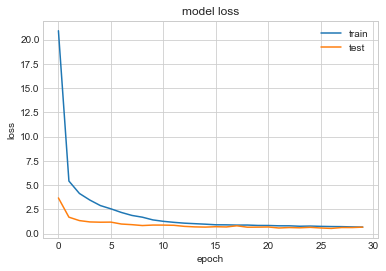

In [92]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

## <a class="anchor" id="3.3-bullet">3.3 Random Forrest</a>


In [142]:
rf = RandomForestRegressor()
rf.fit(X_train_sc, y_train)
rf.score(X_test_sc, y_test)

0.396942495347104

In [143]:
paramz = {
    'max_features': [.4, .5, .7],
    'n_estimators': [90, 100, 150]
    
}
gs = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=paramz)
gs.fit(X_train_sc, y_train)
gs.score(X_test_sc, y_test)

0.4610096696695616

In [114]:
gs.best_params_

{'max_features': 0.4, 'n_estimators': 150}

## <a class="anchor" id="3.4-bullet">3.4 Bagger</a>


In [144]:
br = BaggingRegressor(GradientBoostingRegressor())

br.fit(X_train_sc, y_train)
br.score(X_test_sc, y_test)

0.4282070834923405

## <a class="anchor" id="3.6-bullet">3.7 Comparison</a>


In [145]:
df_big = df_main[df_main.viewCount > 800000000]
df_big_ss = ss.transform(df_big.loc[:, cols_include])

df_big['GradientBoost'] = 10**gb.predict(df_big_ss)
df_big['NeuralNet'] = 10**nn.predict(df_big_ss)
df_big['RandomForest'] = 10**rf.predict(df_big_ss)
df_big['Bagger'] = 10**br.predict(df_big_ss)
df_big['GSForest'] = 10**gs.predict(df_big_ss)
#df_big.viewCount = df_big.viewCount.map(lambda x: '{:.6g}'.format(x))
df_big.loc[:, ['title', 'viewCount', 'RandomForest', 'GSForest','GradientBoost', 'NeuralNet', 'Bagger',]].sort_values(by='viewCount', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.

,title,viewCount,RandomForest,GSForest,GradientBoost,NeuralNet,Bagger
7479,Luis Fonsi - Despacito ft. Daddy Yankee,5555912002,2.496158e+09,8.597120e+08,1.425859e+08,7.625878e+06,8.712146e+07
4268,Ed Sheeran - Shape of You [Official Video],3827104659,8.655010e+07,2.864850e+08,1.978355e+07,5.550064e+06,2.239065e+07
7190,Wiz Khalifa - See You Again ft. Charlie Puth [...,3788737518,9.715079e+08,4.040290e+08,2.394033e+08,4.024046e+07,1.059816e+08
5540,Mark Ronson - Uptown Funk ft. Bruno Mars,3256917992,1.316679e+09,6.812185e+08,6.611473e+07,1.160306e+07,5.597575e+07
3634,PSY - GANGNAM STYLE(강남스타일) M/V,3218413082,3.845512e+08,6.396386e+08,1.665459e+07,1.544227e+06,1.048376e+07
569,Justin Bieber - Sorry (PURPOSE : The Movement),3014897224,2.108729e+06,7.706637e+06,9.482050e+07,4.149746e+06,3.066570e+07
7417,Maroon 5 - Sugar,2756205542,3.822505e+06,1.798069e+06,2.994625e+06,1.691955e+06,4.166016e+06
7514,Taylor Swift - Shake It Off,2650920924,2.180778e+09,6.581992e+08,3.089242e+07,7.743163e+06,2.423377e+07
5506,Katy Perry - Roar (Official),2638406673,1.170080e+09,4.316583e+08,5.894900e+07,1.509130e+07,5.335661e+07
627,Enrique Iglesias - Bailando (Español) ft. Desc...,2582945265,5.121747e+07,3.042361e+07,1.813790e+07,4.943104e+06,1.430484e+07


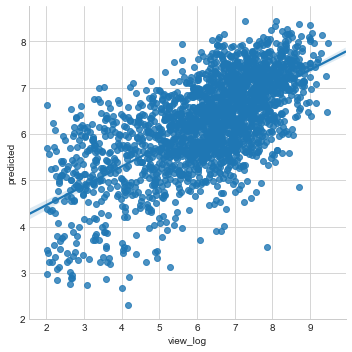

In [8]:
df_residuals = pd.DataFrame(y_test)
df_residuals['predicted'] = gb.predict(X_test_sc)
df_residuals['residuals'] = df_residuals.predicted - df_residuals.view_log 
sns.lmplot('view_log', 'predicted', data=df_residuals)

In [117]:
outliers = list(df_residuals.sort_values(by='residuals').iloc[:7, :].index)
temp = df_main
outliers_df = df_residuals.sort_values(by='residuals').iloc[:7, :].loc[:, ['predicted', 'residuals']]
temp.join(outliers_df, how='right').loc[:, ['title', 'view_log', 'predicted']]

,title,view_log,predicted
4460,I'm Yours(ukulele),7.842553,3.628258
4696,XXXTENTACION - SAD!,8.694612,4.506690
7417,Maroon 5 - Sugar,9.440312,6.351101
7571,Four Seasons ~ Vivaldi,8.261627,5.368098
5337,MC WM - Fuleragem (KondZilla),8.450210,5.579055
5530,Chance the Rapper ft. 2 Chainz & Lil Wayne - N...,8.132406,5.279450
8649,clubbed to death - Matrix soundtrack,7.555912,4.756692


# <a class="anchor" id="4.0-bullet">4.0 Back Testing</a>

## New Pulls

In [71]:
df_new = pd.read_csv('./data/engineered_data/data_engineered_round2_10.14_1545.csv')

In [72]:
df_new_data = df_new[df_new['view_class']>1]

target_new = df_new_data.view_log

df_new_data_sc = df_new_data.loc[:, cols_include]

df_new_data_sc = ss.transform(df_new_data_sc)

preds_new = gb.predict(df_new_data_sc)

In [73]:
gb.score(df_new_data_sc, target_new)

0.43372954536063085

In [74]:
df_new_predicted = df_new_data

df_new_predicted['predicted'] = preds_new

df_new_predicted = df_new_predicted[pd.to_datetime(df_new_predicted.publishedAt)>datetime.datetime(2018, 10, 2)]

df_new_predicted.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(427, 71)

In [75]:
df_new_predicted.loc[:, ['vidId','title', 'view_log', 'predicted']].sort_values(by='predicted', ascending=False)

,vidId,title,view_log,predicted
1965,a3OIkfphUas,F.Lackó-Konditerem (Official Music Video),3.720738,6.533221
8186,SGrqQ4kjoRc,"Sky, Sebastián Yatra, Zion & Lennox - Aquí Estaré",6.825535,6.426265
7395,8CdcCD5V-d8,Eminem - Venom,7.643133,6.379462
6205,6Dh-RL__uN4,TSERIES DISS TRACK,6.907602,6.295509
6754,kNrj87Q-4Yk,Barbra Streisand - Don't Lie to Me (Official V...,5.100674,6.295359
6449,erNfNSCKTjg,Rauw Alejandro x Saox x Lyanno x Sousa x Alvar...,5.364361,6.147870
8372,jda4bMcRseA,Pokahontaz - Z innej bajki (official video) pr...,5.099688,6.026177
1244,kTKxlA1LybE,Tenacious D - MAKING LOVE (Official Audio),4.612794,5.956951
6439,CIK5ZxzDLkA,Jaleo - Nicky Jam X Steve Aoki,6.893836,5.916495
7260,cDWt0TlCUT0,DOGODINE U PRIZRENU - BEOGRADSKI SINDIKAT&TRAG,5.166998,5.851547


In [76]:
df_new_predicted[abs(df_new_predicted.predicted - df_new_predicted.view_log)>2].loc[:, ['vidId','title', 'view_log', 'predicted']].sort_values(by='predicted', ascending=False)

,vidId,title,view_log,predicted
1965,a3OIkfphUas,F.Lackó-Konditerem (Official Music Video),3.720738,6.533221
3948,sw646YfBTc4,Mc do L - Catuaba de Açaí [Web-Clipe Oficial] ...,3.594724,5.680904
2375,YTgf13foo_E,Doppel G & Σάρο - Συννεφιά ☁,2.549003,5.554785
6230,IlogITwDl4w,Rဇာနည္ - အသင့္သူ A Thint' Thu,2.113943,5.549721
2069,CjD7zHbF7U4,Awaken-F（秦奮、韓沐伯、靖佩瑤、秦子墨、左葉）【吸引定律 The Law of At...,3.325721,5.532788
2121,PYmd1blKNsc,[MASHUP] Girls' Generation-Oh!GG & BoA - Lil' ...,2.340444,5.389820
764,f0BapC-y1ls,[MV] Wel.C (웰씨) - Burning (불타고 싶어),2.767898,5.322394
795,aB0LfiJDbAM,Deau - Traça a Linha (c/Letra),2.365488,5.316084
2804,K4bAQtQvl5c,ENTE ROGA KIDAKKAYATHIL | Rajesh H | Fr Shaji ...,2.313867,5.269329
751,6u3Gk6MNHd8,Mini God x Flávio Mc x Rafa G - SUSTI (c/Letra),2.390935,5.227591
